<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-импорт-библиотек" data-toc-modified-id="Загрузка-данных-и-импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и импорт библиотек</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Корреляционный-анализ-признаков" data-toc-modified-id="Корреляционный-анализ-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Корреляционный анализ признаков</a></span></li></ul></li><li><span><a href="#Подготовка-выборок-для-обучения-моделей" data-toc-modified-id="Подготовка-выборок-для-обучения-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка выборок для обучения моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Выводы-по-проделанной-работе" data-toc-modified-id="Выводы-по-проделанной-работе-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы по проделанной работе</a></span></li></ul></div>

# Проект: Определение стоимости автомобилей


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В приложении пользователи смогут узнать рыночную стоимость своего автомобиля. 

Необходимо построить модель, которая будет предсказывать стоимость автомобиля на основе данных о его технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.


**Признаки:**
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя
- **Price** — цена (евро) - **целевой**


## Загрузка данных и импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import numpy as np
import seaborn as sns
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet

In [3]:
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Предобработка данных

Проверим на наличие дубликатов

In [4]:
autos.duplicated().sum()

4

In [5]:
autos = autos.drop_duplicates()

Сохраним количество строк на данный момент, чтобы в дальнейшем узнать количество удаленных строк.

In [6]:
old_count = autos.shape[0]
old_count

354365

Изучим данные о столбцах таблицы

In [7]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(9)
me

Изменим названия столбцов согласно змеиному регистру

In [8]:
autos.columns = [
    'date_crawled', 'price', 'vehicle_type', 'registration_year',
    'gearbox', 'power', 'model', 'kilometer', 'registration_month',
    'fuel_type', 'brand', 'repaired', 'date_created',
    'number_of_pictures', 'postal_code', 'last_seen'
]

Проверим границы даты создания анкеты 

In [9]:
autos['date_created'].min(), autos['date_created'].max()

('2014-03-10 00:00:00', '2016-04-07 00:00:00')

Удалим неинформативные признаки, которые не должны влиять на стоимость автомобиля.
Удаленные признаки содержат информацию о пользователе или о созданной им анкете - они не влияют на стоимость автомобиля. Месяц регистрации анкеты был удален, ведь как отдельный признак он будет только мешать прогнозированию стоимости, а год регистрации - важен.

In [10]:
autos = autos.drop(columns=[
    'date_crawled',
    'registration_month',
    'date_created',
    'number_of_pictures',
    'postal_code',
    'last_seen'
])

In [11]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          321470 non-null  object
 8   brand              354365 non-null  object
 9   repaired           283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Проверим количество пропусков в процентах от общего количества строк

In [12]:
autos.isna().sum() / autos.count() * 100

price                 0.000000
vehicle_type         11.831164
registration_year     0.000000
gearbox               5.928581
power                 0.000000
model                 5.888065
kilometer             0.000000
fuel_type            10.232681
brand                 0.000000
repaired             25.124024
dtype: float64

Пропуски в столбце repaired заменим на unknown, их нельзя удалить, ведь мы потеряем 25% всех данных. Аналогично поступим с пропусками в столбцах vehicle_type, gearbox, model, fuel_type.

In [13]:
autos[['vehicle_type', 'fuel_type', 'repaired', 'model', 'gearbox']] = autos[
    [
        'vehicle_type', 'fuel_type', 'repaired', 'model', 'gearbox'
    ]
].fillna('unknown')

Проверим значения в категориальных столбцах.

In [14]:
categorical_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

for column in categorical_columns:
    print(f"Уникальные значения в столбце {column}:")
    print(sorted(autos[column].unique()))

Уникальные значения в столбце vehicle_type:
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'unknown', 'wagon']
Уникальные значения в столбце gearbox:
['auto', 'manual', 'unknown']
Уникальные значения в столбце model:
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', '

В столбце fuel_type можно объединить категории gasoline и petrol, а также other и unknown.

In [15]:
autos['fuel_type'] = autos['fuel_type'].replace({
    'petrol': 'gasoline',
    'other': 'unknown'
})

Проверим распределение числовых признаков.

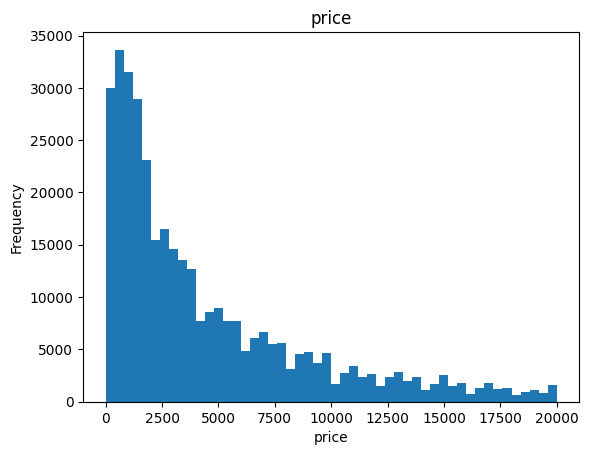

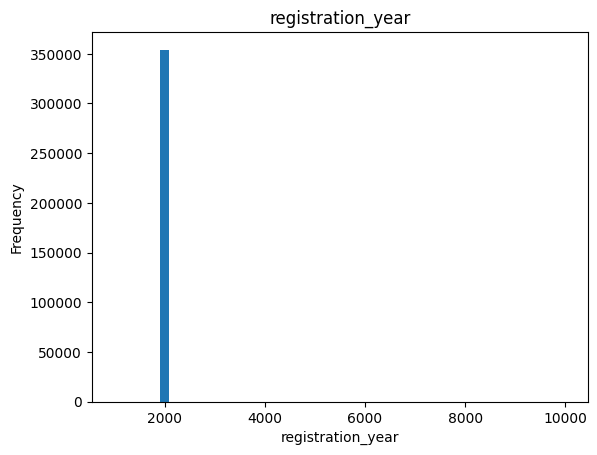

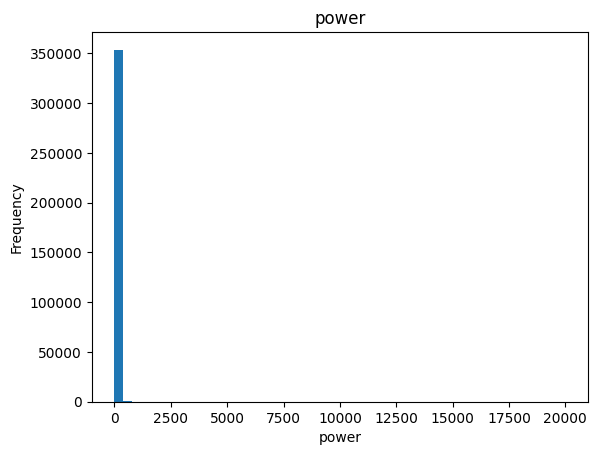

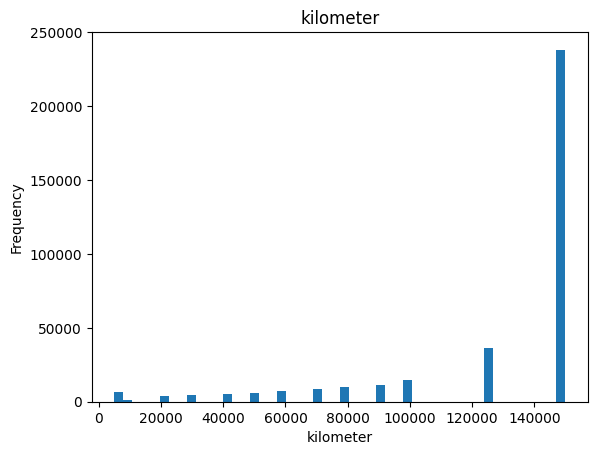

In [16]:
numerical_columns = ['price', 'registration_year', 'power', 'kilometer']

for column in numerical_columns:
    autos[column].plot(kind='hist', title=column, bins=50)
    plt.xlabel(column)
    plt.show()

Удалим все автомобили, стоимость которых меньше 100 евро, мощность которых превышает 2000 л.с. и меньше 40 л.с., и год регистрации которых был после 1980

In [17]:
autos = autos[
    (autos['power'] <= 2000) & 
    (autos['power'] >= 40) & 
    (autos['price'] >= 100) & 
    (autos['registration_year'] >= 1980) & 
    (autos['registration_year'] <= 2016)
]

Посмотрим распределение категориальных признаков (кроме model).

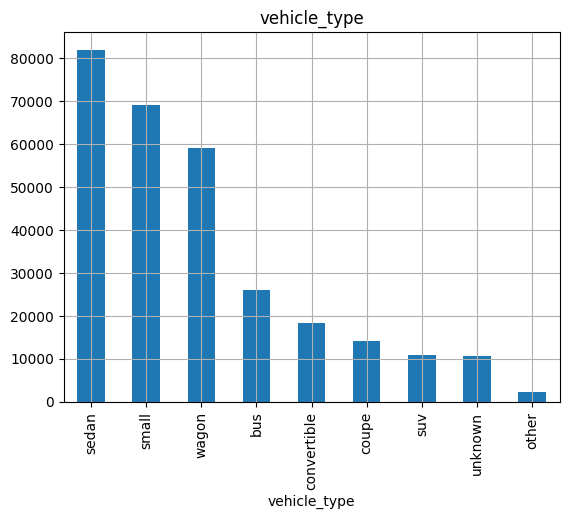

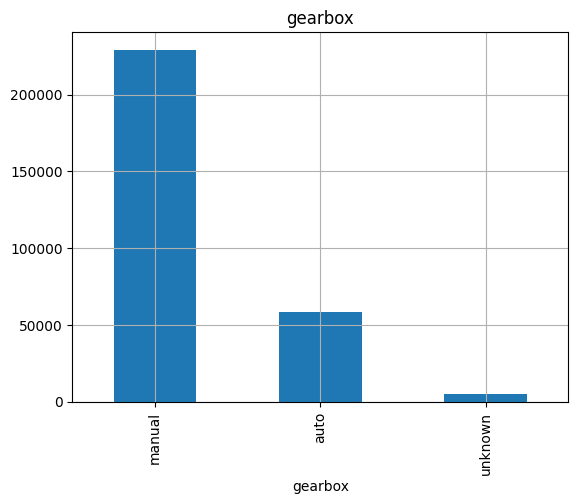

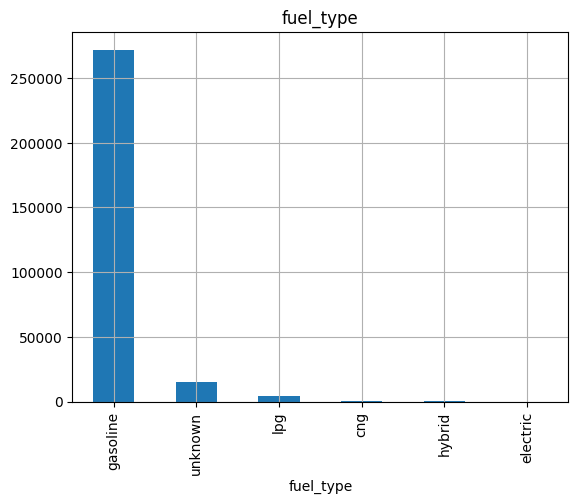

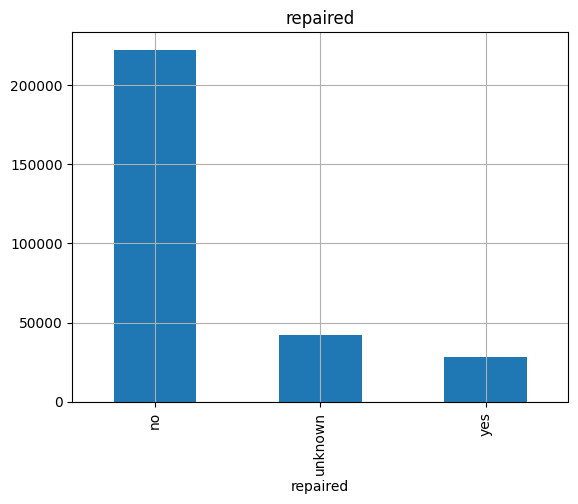

In [18]:
categorical_columns = ['vehicle_type', 'gearbox',  'fuel_type', 'repaired']

for column in categorical_columns:
    autos[column].value_counts().plot(
        kind='bar',
        title=column,
        grid=True
    )
    plt.xlabel(column)
    plt.show()

Чаще всего встречаются автомобили с механической коробкой передач, типом топлива - бензин, и машины, которые никогда не были в ремонте.

### Корреляционный анализ признаков

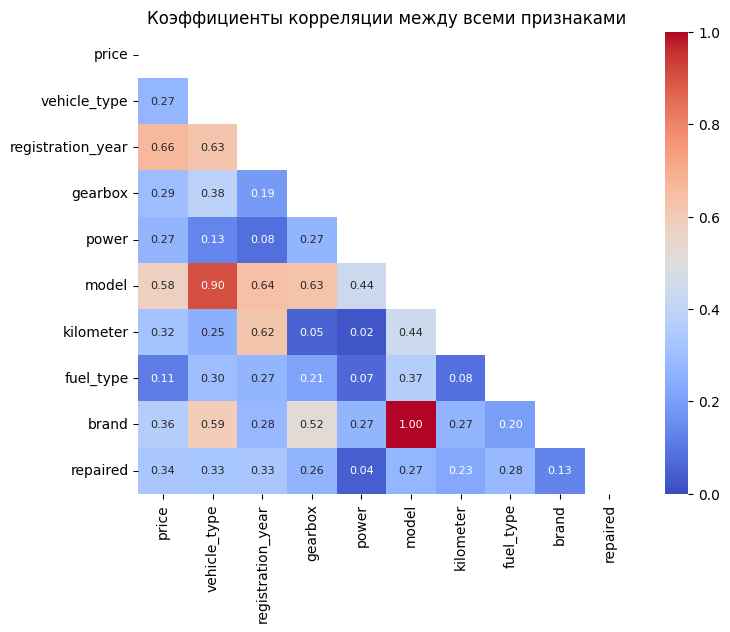

In [19]:
corr_matrix = autos.phik_matrix(interval_cols=['price', 'power', 'kilometer'])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    annot_kws={"fontsize": 8}
)
plt.title('Коэффициенты корреляции между всеми признаками')
plt.show()

Наблюдается мультиколлинеарность между маркой и моделью автомобиля. Объединим данные столбцы.

In [20]:
autos['brand_model'] = autos['brand'] + '_' + autos['model']

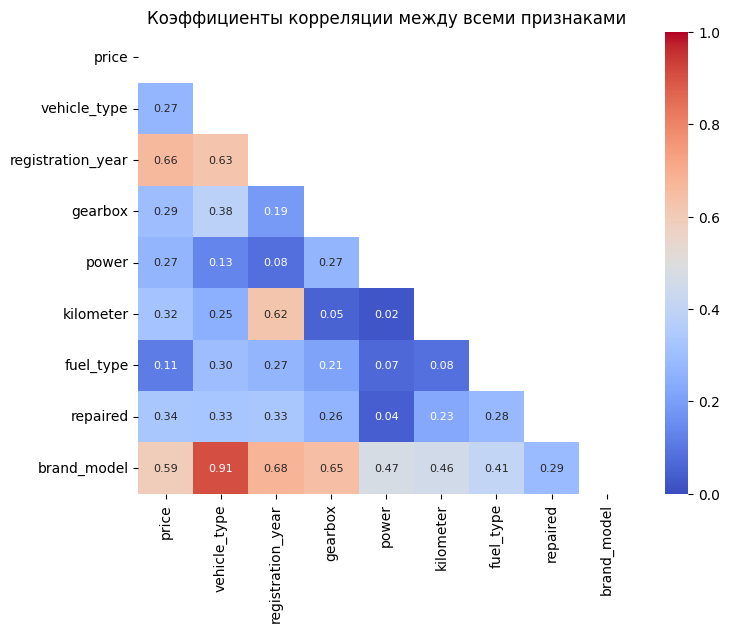

In [21]:
corr_matrix = autos.drop(columns=['brand', 'model']).phik_matrix(
    interval_cols=['price', 'power', 'kilometer']
)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    annot_kws={"fontsize": 8}
)
plt.title('Коэффициенты корреляции между всеми признаками')
plt.show()

Обрзовалась высокая корреляция между brand_model и vehicle_type, но её можно оставить, так как тип автомобиля важен для прогнозирования.

**Выводы:**

1. **Удаление дубликатов** и **изменение названий столбцов** на змеиный регистр.
2. Удалены **неинформативные признаки** (информация о пользователе и анкете).
3. **Пропуски** в категориальных признаках заменены на "unknown".
4. **Удалены выбросы**: автомобили с ценой ниже 100 евро, мощностью выше 2000 л.с. и годом регистрации после 1980 года.
5. Проведен **анализ категориальных признаков**: большинство автомобилей имеют механическую коробку передач, бензиновый двигатель и не были в ремонте.
6. **Корреляционный анализ** выявил мультиколлинеарность между маркой и моделью автомобиля, что привело к объединению этих признаков в новый — `brand_model`.


## Подготовка выборок для обучения моделей

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    autos.drop(['price', 'brand', 'model'], axis=1),
    autos['price'],
    test_size=0.25,
    random_state=12345
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=12345    
)

cat_col_names = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_model']
num_col_names = ['registration_year', 'power', 'kilometer']

for col in cat_col_names:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

Данные были разделены на обучающую и тестовую выборки в пропорции 75% / 25% для дальнейшего использования в модели.

Категориальные признаки (`vehicle_type`, `gearbox`, `fuel_type`, `repaired`, `brand_model`) были преобразованы в тип `category`, чтобы LightGBM смог работать с ними.


## Обучение моделей

### LightGBM

In [49]:
train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=cat_col_names
)
valid_data = lgb.Dataset(
    X_valid, label=y_valid, categorical_feature=cat_col_names   
)

In [50]:
parametres = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': 1
}

In [51]:
start_time_train = time.time()

lgb_model = lgb.train(
    parametres, 
    train_data, 
    valid_sets=[valid_data],    
    num_boost_round=1000
)

end_time_train = time.time()
training_time = end_time_train - start_time_train
print()
print(f'Время обучения модели LightGBM: {training_time:.2f} секунд')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 164515, number of used features: 8
[LightGBM] [Info] Start training from score 4854.899492

Время обучения модели LightGBM: 5.19 секунд


In [52]:
start_time_predict = time.time()

y_pred_lgb = lgb_model.predict(X_valid)   

end_time_predict = time.time()
prediction_time = end_time_predict - start_time_predict

print(f"Время предсказания LightGBM: {prediction_time:.2f} секунд")

Время предсказания LightGBM: 0.32 секунд


In [53]:
rmse_lgb = root_mean_squared_error(y_valid, y_pred_lgb)  
print(f'LightGBM RMSE = {rmse_lgb:.4f}')

LightGBM RMSE = 1521.2545


Обучена модель LightGBM. Время обучения модели: 5.70 секунд. Время предсказания: 0.50 секунд. RMSE = 1526.7294, что соответствует условию задачи.

### CatBoost

In [54]:
start_time_train = time.time()

catboost_model = CatBoostRegressor(
    objective='RMSE', 
    iterations=1000, 
    learning_rate=0.1, 
    depth=6,
    verbose=100
)

catboost_model.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),  
    cat_features=cat_col_names
)

end_time_train = time.time()
training_time = end_time_train - start_time_train
print(f"Время обучения модели CatBoost: {training_time:.2f} секунд")

0:	learn: 4289.7161269	test: 4311.5992134	best: 4311.5992134 (0)	total: 37.8ms	remaining: 37.7s
100:	learn: 1759.5259275	test: 1796.4545265	best: 1796.4545265 (100)	total: 3.23s	remaining: 28.8s
200:	learn: 1684.0339559	test: 1726.4159967	best: 1726.4159967 (200)	total: 6.12s	remaining: 24.3s
300:	learn: 1637.9542228	test: 1685.9637348	best: 1685.9637348 (300)	total: 9.09s	remaining: 21.1s
400:	learn: 1610.1795370	test: 1663.7948673	best: 1663.7948673 (400)	total: 12s	remaining: 17.9s
500:	learn: 1588.2298412	test: 1647.1981259	best: 1647.1981259 (500)	total: 15s	remaining: 15s
600:	learn: 1571.6197153	test: 1636.1732162	best: 1636.1732162 (600)	total: 18.1s	remaining: 12s
700:	learn: 1556.5695433	test: 1625.3838389	best: 1625.3838389 (700)	total: 20.8s	remaining: 8.88s
800:	learn: 1544.8879940	test: 1618.8637369	best: 1618.8637369 (800)	total: 23.5s	remaining: 5.84s
900:	learn: 1535.6237666	test: 1613.7564516	best: 1613.7564516 (900)	total: 26.3s	remaining: 2.89s
999:	learn: 1524.8243

In [55]:
start_time_predict = time.time()

y_pred_cat = catboost_model.predict(X_valid)

end_time_predict = time.time()
prediction_time = end_time_predict - start_time_predict
print(f"Время предсказания CatBoost: {prediction_time:.2f} секунд")

Время предсказания CatBoost: 0.06 секунд


In [56]:
rmse_cat = root_mean_squared_error(y_valid, y_pred_cat)
print(f'CatBoost RMSE = {rmse_cat:.4f}')

CatBoost RMSE = 1607.7270


Обучена модель CatBoost. Время обучения модели: 37.66 секунд . Время предсказания: 0.10 секунд. RMSE = 1625.7896, что соответствует условию задачи.

### DecisionTreeRegressor

In [57]:
from sklearn.tree import DecisionTreeRegressor

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_valid_ohe = encoder.transform(X_valid[cat_col_names]) 

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_scaled = scaler.transform(X_valid[num_col_names]) 

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder.get_feature_names_out())
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder.get_feature_names_out()) 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names) 

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1) 

dt_model = DecisionTreeRegressor(random_state=42, max_depth=15, min_samples_split=15, min_samples_leaf=5)

start_time_train = time.time()
dt_model.fit(X_train, y_train)
end_time_train = time.time()

training_time = end_time_train - start_time_train
print(f"Время обучения модели DecisionTree: {training_time:.2f} секунд")

Время обучения модели DecisionTree: 2.12 секунд


In [58]:
start_time_predict = time.time()
y_pred_dt = dt_model.predict(X_valid) 
end_time_predict = time.time()

prediction_time = end_time_predict - start_time_predict
print(f"Время предсказания: {prediction_time:.2f} секунд")

Время предсказания: 0.06 секунд


In [59]:
rmse_dt = root_mean_squared_error(y_valid, y_pred_dt) 
print(f'DecisionTree RMSE = {rmse_dt:.4f}')

DecisionTree RMSE = 1840.1351


Обучена модель DecisionTreeRegressor. Время обучения модели: 3.46 секунд. Время предсказания: 0.09 секунд.RMSE = 1852.0084


In [60]:
best_model = min([(rmse_lgb, 'LightGBM'), (rmse_cat, 'CatBoost'), (rmse_dt, 'DecisionTree')])[1]
print(f'Лучшая модель: {best_model}')

Лучшая модель: LightGBM


|           | Время обучения | Время предсказания | RMSE |
|-----------|------|------|------|
| **LightGBM**     | 5.16 | 0.37 | **1521.2545** |
| **CatBoost**       | 29.09 | **0.06** | 1607.7270 |
| **DecisionTree** | **2** | **0.07** | 1840.1351 |


Проведем тестирование лучшей модели

In [61]:
if best_model == 'LightGBM':
    final_model = lgb_model
elif best_model == 'CatBoost':
    final_model = catboost_model
else:
    final_model = dt_model

In [63]:
y_pred_test = final_model.predict(X_test)

rmse_test = root_mean_squared_error(y_test, y_pred_test)
print(f'Тестовая RMSE ({best_model}): {rmse_test:.4f}')

Тестовая RMSE (LightGBM): 1497.5615


**Вывод:** LightGBM показала лучшую метрику RMSE, при этом время обучения модели составило всего 5 секунд. DecisionTreeRegressor справилась хуже всех, однако обучилась всего за 2 секунды, разница незначительная, поэтому предпочтение отдается LightGBM. CatBoost - RMSE = 1607.7270, но обучалась 30 секунд, что крайне долго по сравнению с конкурентами. На тестовой выборке LightGBM показала метрику RMSE = 1497.5615, что даже лучше, чем на валидационной

## Выводы по проделанной работе


1. Были удалены дубликаты данных и приведены названия столбцов к змеиному регистру для улучшения читабельности.
2. Удалены неинформативные признаки, такие как информация о пользователе и анкете, так как они не влияли на прогнозирование стоимости автомобиля.
3. Все пропуски в категориальных столбцах были заменены на значение "unknown" для предотвращения потери данных.
4. Выбросы, такие как автомобили с ценой ниже 100 евро и мощностью выше 2000 л.с., были удалены для повышения качества модели.
5. В ходе анализа категориальных признаков было выявлено, что большинство автомобилей имеют механическую коробку передач, бензиновый двигатель и не были в ремонте.
6. Корреляционный анализ показал высокую взаимосвязь между маркой и моделью автомобиля, что привело к объединению этих признаков в новый столбец `brand_model`.
7. Данные были разделены на обучающую и тестовую выборки в пропорции 75% / 25% для дальнейшего использования в модели.
8. Обучение моделей:
    - **LightGBM** показала лучшие результаты с RMSE = 1521.2545, а время обучения составило 5 секунд, время предсказания — 0.5 секунд.
    - **CatBoost** продемонстрировала RMSE = 1607.7270, но время обучения составило 30 секунд, что значительно дольше по сравнению с LightGBM и DecisionTreeRegressor.
    - **DecisionTreeRegressor** показала RMSE = 1840.1351, что является наихудшим результатом. Время обучения составило 2 секунд, что быстро, но метрика точности оказалась хуже.

**Заключение:** Модель **LightGBM** является наиболее оптимальной, так как она показала лучшее качество предсказаний и наименьшее время обучения и предсказания по сравнению с другими моделями.
